In [154]:
import numpy as np
from matplotlib import pyplot as plt
import copy
import time

## SOM by smith

In [79]:
import numpy as np

class SOM_smith():
    """
    The 2-D, rectangular grid self-organizing map class using Numpy.
    """
    def __init__(self, m=3, n=3, dim=3, lr=1, sigma=1, max_iter=3000,
                    random_state=None):
        """
        Parameters
        ----------
        m : int, default=3
            The shape along dimension 0 (vertical) of the SOM.
        n : int, default=3
            The shape along dimesnion 1 (horizontal) of the SOM.
        dim : int, default=3
            The dimensionality (number of features) of the input space.
        lr : float, default=1
            The initial step size for updating the SOM weights.
        sigma : float, optional
            Optional parameter for magnitude of change to each weight. Does not
            update over training (as does learning rate). Higher values mean
            more aggressive updates to weights.
        max_iter : int, optional
            Optional parameter to stop training if you reach this many
            interation.
        random_state : int, optional
            Optional integer seed to the random number generator for weight
            initialization. This will be used to create a new instance of Numpy's
            default random number generator (it will not call np.random.seed()).
            Specify an integer for deterministic results.
        """
        # Initialize descriptive features of SOM
        self.m = m
        self.n = n
        self.dim = dim
        self.shape = (m, n)
        self.initial_lr = lr
        self.lr = lr
        self.sigma = sigma
        self.max_iter = max_iter

        # Initialize weights
        self.random_state = random_state
        rng = np.random.default_rng(random_state)
        self.weights = rng.normal(size=(m * n, dim))
        self._locations = self._get_locations(m, n)

        # Set after fitting
        self._inertia = None
        self._n_iter_ = None
        self._trained = False

    def _get_locations(self, m, n):
        """
        Return the indices of an m by n array.
        """
        return np.argwhere(np.ones(shape=(m, n))).astype(np.int64)

    def _find_bmu(self, x):
        """
        Find the index of the best matching unit for the input vector x.
        """
        # Stack x to have one row per weight
        x_stack = np.stack([x]*(self.m*self.n), axis=0)
        # Calculate distance between x and each weight
        distance = np.linalg.norm(x_stack - self.weights, axis=1)
        # Find index of best matching unit
        return np.argmin(distance)

    def step(self, x):
        """
        Do one step of training on the given input vector.
        """
        # Stack x to have one row per weight
        x_stack = np.stack([x]*(self.m*self.n), axis=0)

        # Get index of best matching unit
        bmu_index = self._find_bmu(x)

        # Find location of best matching unit
        bmu_location = self._locations[bmu_index,:]

        # Find square distance from each weight to the BMU
        stacked_bmu = np.stack([bmu_location]*(self.m*self.n), axis=0)
        bmu_distance = np.sum(np.power(self._locations.astype(np.float64) - stacked_bmu.astype(np.float64), 2), axis=1)

        # Compute update neighborhood
        neighborhood = np.exp((bmu_distance / (self.sigma ** 2)) * -1)
        local_step = self.lr * neighborhood

        # Stack local step to be proper shape for update
        local_multiplier = np.stack([local_step]*(self.dim), axis=1)

        # Multiply by difference between input and weights
        delta = local_multiplier * (x_stack - self.weights)

        # Update weights
        self.weights += delta

    def _compute_point_intertia(self, x):
        """
        Compute the inertia of a single point. Inertia defined as squared distance
        from point to closest cluster center (BMU)
        """
        # Find BMU
        bmu_index = self._find_bmu(x)
        bmu = self.weights[bmu_index]
        # Compute sum of squared distance (just euclidean distance) from x to bmu
        return np.sum(np.square(x - bmu))

    def fit(self, X, epochs=1, shuffle=True):
        """
        Take data (a tensor of type float64) as input and fit the SOM to that
        data for the specified number of epochs.
        Parameters
        ----------
        X : ndarray
            Training data. Must have shape (n, self.dim) where n is the number
            of training samples.
        epochs : int, default=1
            The number of times to loop through the training data when fitting.
        shuffle : bool, default True
            Whether or not to randomize the order of train data when fitting.
            Can be seeded with np.random.seed() prior to calling fit.
        Returns
        -------
        None
            Fits the SOM to the given data but does not return anything.
        """
        # Count total number of iterations
        global_iter_counter = 0
        n_samples = X.shape[0]
        total_iterations = np.minimum(epochs * n_samples, self.max_iter)

        for epoch in range(epochs):
            # Break if past max number of iterations
            if global_iter_counter > self.max_iter:
                break

            if shuffle:
                rng = np.random.default_rng(self.random_state)
                indices = rng.permutation(n_samples)
            else:
                indices = np.arange(n_samples)

            # Train
            for idx in indices:
                # Break if past max number of iterations
                if global_iter_counter > self.max_iter:
                    break
                input = X[idx]
                # Do one step of training
                self.step(input)
                # Update learning rate
                global_iter_counter += 1
                self.lr = (1 - (global_iter_counter / total_iterations)) * self.initial_lr

        # Compute inertia
        inertia = np.sum(np.array([float(self._compute_point_intertia(x)) for x in X]))
        self._inertia_ = inertia

        # Set n_iter_ attribute
        self._n_iter_ = global_iter_counter

        # Set trained flag
        self._trained = True

        return

    def predict(self, X):
        """
        Predict cluster for each element in X.
        Parameters
        ----------
        X : ndarray
            An ndarray of shape (n, self.dim) where n is the number of samples.
            The data to predict clusters for.
        Returns
        -------
        labels : ndarray
            An ndarray of shape (n,). The predicted cluster index for each item
            in X.
        """
        # Check to make sure SOM has been fit
        if not self._trained:
            raise NotImplementedError('SOM object has no predict() method until after calling fit().')

        # Make sure X has proper shape
        assert len(X.shape) == 2, f'X should have two dimensions, not {len(X.shape)}'
        assert X.shape[1] == self.dim, f'This SOM has dimesnion {self.dim}. Received input with dimension {X.shape[1]}'

        labels = np.array([self._find_bmu(x) for x in X])
        return labels

    def transform(self, X):
        """
        Transform the data X into cluster distance space.
        Parameters
        ----------
        X : ndarray
            Data of shape (n, self.dim) where n is the number of samples. The
            data to transform.
        Returns
        -------
        transformed : ndarray
            Transformed data of shape (n, self.n*self.m). The Euclidean distance
            from each item in X to each cluster center.
        """
        # Stack data and cluster centers
        X_stack = np.stack([X]*(self.m*self.n), axis=1)
        cluster_stack = np.stack([self.weights]*X.shape[0], axis=0)

        # Compute difference
        diff = X_stack - cluster_stack

        # Take and return norm
        return np.linalg.norm(diff, axis=2)

    def fit_predict(self, X, **kwargs):
        """
        Convenience method for calling fit(X) followed by predict(X).
        Parameters
        ----------
        X : ndarray
            Data of shape (n, self.dim). The data to fit and then predict.
        **kwargs
            Optional keyword arguments for the .fit() method.
        Returns
        -------
        labels : ndarray
            ndarray of shape (n,). The index of the predicted cluster for each
            item in X (after fitting the SOM to the data in X).
        """
        # Fit to data
        self.fit(X, **kwargs)

        # Return predictions
        return self.predict(X)

    def fit_transform(self, X, **kwargs):
        """
        Convenience method for calling fit(X) followed by transform(X). Unlike
        in sklearn, this is not implemented more efficiently (the efficiency is
        the same as calling fit(X) directly followed by transform(X)).
        Parameters
        ----------
        X : ndarray
            Data of shape (n, self.dim) where n is the number of samples.
        **kwargs
            Optional keyword arguments for the .fit() method.
        Returns
        -------
        transformed : ndarray
            ndarray of shape (n, self.m*self.n). The Euclidean distance
            from each item in X to each cluster center.
        """
        # Fit to data
        self.fit(X, **kwargs)

        # Return points in cluster distance space
        return self.transform(X)

    @property
    def cluster_centers_(self):
        return self.weights.reshape(self.m, self.n, self.dim)

    @property
    def inertia_(self):
        if self._inertia_ is None:
            raise AttributeError('SOM does not have inertia until after calling fit()')
        return self._inertia_

    @property
    def n_iter_(self):
        if self._n_iter_ is None:
            raise AttributeError('SOM does not have n_iter_ attribute until after calling fit()')
        return self._n_iter_

## Dataset objects

In [115]:
class sample_random_balls(object):
    
    def __init__(self, n_centers, var_x = 1, var_y = 1, var_xy = 0, x_range = [-10, 10], y_range = [-10, 10], rotate = False):
        """
        Want to sample K blobs, with n_points per blob. Diversity range is controlled by x_range and y_range
        """
        
        self.n_centers = n_centers
        self.covariance = np.array([[var_x, var_xy], 
                                    [var_xy, var_y]])
        
        self.x_centers = np.random.random_sample(n_centers) * (x_range[1] - x_range[0]) + x_range[0]
        self.y_centers = np.random.random_sample(n_centers) * (y_range[1] - y_range[0]) + y_range[0]
        
        self.mu = np.vstack([self.x_centers, self.y_centers]).T
    
    def sample(self, n_points):
        #Find any real matrix A such that A.A^T = Cov. If Cov is positive definite, Cholesky decomposition can be used.
        #Alternatively, use spectral decomposition Cov = U.S.U^(-1) (A = U.sqrt(S)) (U is the eigenvector matrix)
        #Let z = (z_1, ..., z_n)^T be a vector whose components are N independent standard normal variables
        #let x = mu + Az.
        
        #Positive definite - x^T A x > 0 for all x (all eigenvalues are positive)
        #Positive semi-definite - x^T A x >= 0 for all x (all eigenvalues are non-negative)
        
        eig_vals, eig_vect = np.linalg.eig(self.covariance)
        
        if np.sum(eig_vals > 0) == 2:
            print("\nCovariance is positive definite.")
            
            A = np.linalg.cholesky(self.covariance)
            
        elif np.sum(eig_vals >= 0) == 2:
            print("\nCovariance is positive semi-definite.")
            
            A = np.dot(eig_vect, np.diag(np.sqrt(eig_vals)))
        
        
        point_samples = np.random.randint(low = 0, high = self.n_centers, size = n_points)
        
        z = np.random.randn(n_points, 2)
        x = self.mu[point_samples, :] + np.dot(A, z.T).T
        
        return x, point_samples
    
class s_manifold_2d(object):
    
    def __init__(self, n_circles = 2, radius = 1, noise_var = 0, rotation = 0, y_offset = 0):
        
        self.n_circles = n_circles
        self.radius = radius
        self.noise_var = noise_var
        self.rotation = np.radians(rotation)
        self.y_offset = y_offset
        
        #Make the centers
        self.make_centers() 
        
        #Make circle sample likelihood
        self.generate_likelihood()
        
    def make_centers(self):
        
        self.y_pos = np.ones(self.n_circles) * self.y_offset
        
        if self.n_circles % 2 == 0:
            
            print("There are an even number of circles")
            
            n_sides = self.n_circles // 2
            x_pos = [self.radius]
            
            for i in range(n_sides - 1):
                x_pos.append(x_pos[-1] + 2 * self.radius)
            
            #reverse and do the other side
            x_pos = x_pos[::-1]
            
            for i in range(n_sides):
                x_pos.append(x_pos[-1] - 2 * self.radius)
            
            #Unreverse
            x_pos = x_pos[::-1]
            
            #Store 
            self.x_pos = x_pos
            
            
        else:
            print("There are an odd number of circles")
            
            x_pos = [0]
            
            n_sides = (self.n_circles - 1) // 2
            
            for i in range(n_sides):
                x_pos.append(x_pos[-1] + 2 * self.radius)
            
            #reverse and do the other side
            x_pos = x_pos[::-1]
            
            for i in range(n_sides):
                x_pos.append(x_pos[-1] - 2 * self.radius)
            
            #Unreverse
            x_pos = x_pos[::-1]
            
            #Store 
            self.x_pos = np.array(x_pos)
        
        self.circle_centers = np.vstack((self.x_pos, self.y_pos)).T
    
    def rotate_positions(self, X):
        
        R_mat = np.array([[np.cos(self.rotation), -np.sin(self.rotation)],
                          [np.sin(self.rotation), np.cos(self.rotation)]])
        
        return np.dot(X, R_mat.T)
    
    def generate_likelihood(self):
        #Basic for now
        self.circle_likelihood = np.ones(self.n_circles) / self.n_circles
    
    def class_sampler(self, n_samples):
        
        cumsum = np.cumsum(self.circle_likelihood)
        
        rand_sample = np.random.rand(n_samples, 1)
        
        classes = np.argmax(cumsum > rand_sample, axis = 1)
        
        return classes.astype('int')
    
    def sample(self, n_samples):
        
        cumsum = self.circle_likelihood
        start_sign = np.array([(-1)**(np.arange(1, self.n_circles + 1, 1))]).T
        
        class_sample = self.class_sampler(n_samples)
        
        centers = self.circle_centers[class_sample, :]
        
        LB_x = centers[:, [0]] - self.radius
        UP_x = centers[:, [0]] + self.radius
        
        #Random points
        x_random = np.random.rand(n_samples, 1)
        
        #Shift to bounds
        x_samples = x_random * (UP_x - LB_x) + LB_x
        
        #generate_points
        y_samples = centers[:, [1]] + start_sign[class_sample] * np.sqrt(self.radius**2 - (x_samples - centers[:, [0]])**2)
        
        print(x_samples.shape, y_samples.shape)
        
        X = np.hstack((x_samples, y_samples)) 
        
        #Add noise
        X += np.random.randn(*X.shape) * self.noise_var
        
        X = self.rotate_positions(X)
        
        return X

## SOM object

In [179]:
class SOM(object):
    
    def __init__(self, n_neurons, n_features, n_epochs, n_init = 1, lr = None, radius = None, standardise_flag = True, verbose = False, vectorise = False):
        
        self.n_features = n_features
        
        if n_neurons is None:
            n_neurons = 5 * int(np.sqrt(self.n_features)) # 5 * floor(sqrt(n_features))
            
            self.n_rows = int(np.sqrt(n_neurons))
            self.n_cols = int(n_neurons / self.n_rows)
            self.n_neurons = int(self.n_rows * self.n_cols)
            
            print("Initialised size: [{}, {}]".format(self.n_rows, self.n_cols))
            
        else:
            self.n_rows, self.n_cols = n_neurons
            self.n_neurons = int(self.n_rows * self.n_cols)
        
        self.n_epochs = n_epochs
        self.n_init = n_init
        self.random_state = np.random.mtrand._rand
        
        #learning rate
        if lr is None:
            self.lr_0 = 0.9
            self.lr_1 = 0.1
            
        
        else:
            self.lr_0, self.lr_1 = lr
        
        self.lambda_lr = self.n_epochs / (-1 * np.log(self.lr_1 / self.lr_0))
        
        #radius
        if radius is None:
            self.radius_0 = 1
            self.radius_1 = 0.01
            
        
        else:
            self.radius_0, self.radius_1 = radius
        
        self.lambda_radius = self.n_epochs / (-1 * np.log(self.radius_1 / self.radius_0))
        
        self.standardise_flag = standardise_flag
        self.verbose = verbose
        self.vectorise = vectorise #Used to speed up the quantisation process 
        
        #create grid
        self.create_grid()
    
    def create_grid(self):
        
        X, Y = np.meshgrid(np.arange(0, self.n_rows, 1), np.arange(0, self.n_cols, 1))
        
        self.grid_points = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
    
    def plot_grid(self, ax_object):
        
        if self.n_features == 2:
            for i in range(self.n_rows * self.n_cols):

                P0 = self.grid_points[[i], :]

                dist = np.sum((self.grid_points[i:, :] - P0)**2, axis = 1) #No need to do redundant points
                
                pos = np.argwhere(dist == 1)[:, 0] + i #Need to shift positions
                
                for j in pos:
                    
                    x0, y0 = self.weights_[i, :]
                    x1, y1 = self.weights_[j, :]

                    ax_object.plot([x0, x1], [y0, y1], "k--")
        
            return ax_object
        
        else:
            return ax_object
    
    def frequency_map(self, X):
        
        #Two figures, one is a pcolormesh, the other is a matrix of points
        
        N, _ = X.shape
        
        cnt_weights = np.zeros(self.n_neurons)
        
        for i in range(N):
            
            bmu_index, _ = self.get_bmu(X[i, :])
            cnt_weights[bmu_index] += 1
        
        
        freq_mat = cnt_weights.reshape(self.n_rows, self.n_cols)
        
        fig, ax = plt.subplots(1, 1, figsize = (10, 8))
        
        ax.set_title("Frequency counts")
        mat = ax.matshow(freq_mat, cmap = plt.cm.cool)
        fig.colorbar(mat, ax=ax)
        plt.show()
    
    def distance_map(self):
        
        dist_map = np.zeros((self.n_rows, self.n_cols))
        
        for i in range(self.n_rows * self.n_cols):

            P0 = self.grid_points[[i], :]

            dist = np.sum((self.grid_points - P0)**2, axis = 1) #No need to do redundant points

            pos = np.argwhere(dist == 1)[:, 0]
            
            distance = 0
            P0 = P0[0, :]
            
            for j in pos:
                
                P1 = self.weights_[j, :]
                
                distance += np.linalg.norm(P0 - P1)
            
            dist_map[P0[0], P0[1]] = distance
        
        return dist_map / np.max(dist_map)
        
        
        
    def u_matrix_2x2(self, weights_2x2):
        
        u_new = np.zeros((3, 3))
        
        #weights_2x2 is a 2 x 2 x N matrix
        
        #outside nodes
        u_new[0, 1] = np.linalg.norm(weights_2x2[0, 0, :] - weights_2x2[0, 1, :]) #Shared between (0, 0) and (0, 1)
        u_new[1, 0] = np.linalg.norm(weights_2x2[0, 0, :] - weights_2x2[1, 0, :]) #Shared between (0, 0) and (1, 0)
        u_new[1, 2] = np.linalg.norm(weights_2x2[0, 1, :] - weights_2x2[1, 1, :]) #Shared between (0, 1) and (1, 1)
        u_new[2, 1] = np.linalg.norm(weights_2x2[1, 0, :] - weights_2x2[1, 1, :]) #Shared between (1, 0) and (1, 1)
        
        #corner nodes
        u_new[0, 0] = (u_new[0, 1] + u_new[1, 0]) / 2 #upper left
        u_new[0, 2] = (u_new[0, 1] + u_new[2, 2]) / 2 #upper right
        u_new[2, 0] = (u_new[1, 0] + u_new[2, 1]) / 2 #lower left
        u_new[2, 2] = (u_new[2, 1] + u_new[1, 2]) / 2 #lower right
        
        #Middle node
        u_new[1, 1] = (u_new[0, 1] + u_new[1, 0] + u_new[2, 1] + u_new[1, 2]) / 4 #middle node
        
        
        return u_new
        
        
    def Umatrix(self):
        
        n_rows_new = (self.n_rows + (self.n_rows - 1))
        n_cols_new = (self.n_cols + (self.n_cols - 1))
        
        u_mat = np.zeros((n_rows_new, n_cols_new))
        
        print("Not finished! Please fix")
        
        #for i in range(self.n_cols):
            
            #for j in range(self.n_rows):
                
                #pass #WHAT AM I TRYING TO DO HERE???
        
        
        
    def exponential_scheduler(self, epoch, lr_flag = True):
        
        if lr_flag:
            lambda_val = self.lambda_lr
            N0 = self.lr_0
        
        else:
            lambda_val = self.lambda_radius
            N0 = self.radius_0
            
        return N0 * np.exp(- epoch / lambda_val)
    
    def initialise_weights(self):
        
        return np.random.randn(self.n_neurons, self.n_features)
    
    def standardise(self, X, reverse_flag = False):
        
        if reverse_flag:
            
            if hasattr(self, "mean_") and hasattr(self, "std_"):
            
                return X * self.std_ + self.mean_
            
            else:
                print("Error in standardisation. No mean_ and std_ attributes")
                raise SystemExit
        
        else:
            self.mean_ = np.mean(X, axis = 0, keepdims = True)
            self.std_ = np.std(X, axis = 0, keepdims = True)

            return (X - self.mean_) / self.std_
    
        
    @staticmethod
    def euclidean_distance(x0, x1):
        
        return np.sqrt(np.sum((x0 - x1)**2, axis = 1, keepdims = True))
    
    @staticmethod
    def euclidean_neighbourhood(d_ci, radius_t):
        
        return np.exp(-1 * (d_ci**2) / (2 * radius_t**2))
    
    def get_bmu(self, x):
        
        #Compute distance
        dist = self.euclidean_distance(self.weights_, x)

        #Select BMU
        c_index = np.argmin(dist)
        
        return c_index, dist[c_index, 0]
        
    def calculate_inertia(self, X):
        
        N, f = X.shape
        m = self.n_neurons
        if self.vectorise:
            
            #Increase shapes
            X = copy.deepcopy(X).reshape(N, 1, f).repeat(m, axis = 1)
            #X = np.expand_dims(X, axis = 1)
            #X = np.repeat(X, self.n_neurons, axis = 1)
            
            weights = np.expand_dims(self.weights_, axis = 0)
            
            #Calculate distances
            dist = np.sqrt(np.sum((X - weights)**2, axis = 2))
            
            #select quantisation error
            quantisation_error = np.min(dist, axis = 1)
            
        else:
            quantisation_error = np.zeros(N)
            
            for i in range(N):

                _, min_dist = self.get_bmu(X[i, :])
                quantisation_error[i] = min_dist

        return np.sum(quantisation_error**2), np.mean(quantisation_error)
    
    def update_weights(self, x, bmu_index, lr, radius):
        
        #Calculate grid distances
        
        d_ci = self.euclidean_distance(self.grid_points[[bmu_index], :], self.grid_points)
        
        #Calculate Euclidean scale
        scale = self.euclidean_neighbourhood(d_ci, radius)
        
        #Calculate Hc
        Hc = lr * scale
        
        #Update weights     
        delta_w = Hc * (x - self.weights_)
        
        energy = np.sum((delta_w)**2)
        
        self.weights_ += delta_w
        
        return energy
    
    def fit(self, X, calculate = True):
        
        if self.verbose:
            print("\nStarting the SOM training!")
        n_samples, n_features = X.shape
        
        assert(n_features == self.n_features), "Features not aligned."
        
        if self.standardise_flag:
            X = copy.deepcopy(X)
            X = self.standardise(X, reverse_flag = False)
        
        #Initialise iteration dictionary
        iter_dict = {}
        
        #Initialise location properties
        optimal_inertia = np.inf
        optimal_outer = None
        
        for outer_iter in range(self.n_init):
            if self.verbose:
                print("\nStarting iteration {}...".format(outer_iter + 1))
        
            #Initialise problem
            self.t = 0
            self.weights_ = self.initialise_weights()
            training_inertia = np.zeros(self.n_epochs)
            quantisation_error = np.zeros(self.n_epochs)
            training_energy = np.zeros(self.n_epochs)

            cnt = 0

            while self.t < self.n_epochs:

                #Select random vector
                random_index = self.random_state.randint(0, 100)
                x_selected = X[random_index, :]

                #find bmu
                bmu_index, _ = self.get_bmu(x_selected)

                #Calculate radius and learning_rate
                lr_t = self.exponential_scheduler(self.t, lr_flag = True)
                radius_t = self.exponential_scheduler(self.t, lr_flag = False)

                #Update weights
                energy_t = self.update_weights(x_selected, bmu_index, lr_t, radius_t)

                #Update time
                self.t += 1

                #Calculate_inertia
                if calculate:
                    training_inertia[cnt], quantisation_error[cnt] = self.calculate_inertia(X)
                    
                #Save energy
                training_energy[cnt] = energy_t

                cnt += 1
            
            if self.verbose:
                print("Final inertia: {:.4f}\nFinal quantisation error: {:.4f}".format(training_inertia[-1], quantisation_error[-1]))
            
            iter_dict[str(outer_iter)] = {"weights":self.weights_,
                                          "training_inertia":training_inertia,
                                          "training_energy":training_energy,
                                          "quantisation_error":quantisation_error}
            
            if optimal_inertia > training_inertia[-1]:
                optimal_inertia = training_inertia[-1]
                optimal_outer = outer_iter
        
        if self.verbose:
            print("\nFinished SOM training!")
        
        #Save properties
        self.weights_ = iter_dict[str(optimal_outer)]["weights"]
        self.training_inertia_ = iter_dict[str(optimal_outer)]["training_inertia"]
        self.training_energy_ = iter_dict[str(optimal_outer)]["training_energy"]
        self.quantisation_error_ = iter_dict[str(optimal_outer)]["quantisation_error"]
        
        self._inertia_, self._quantisation_error_ = self.calculate_inertia(X)
        
        #Save final weights
        if self.standardise_flag:
            self.weights_ = self.standardise(self.weights_, reverse_flag = True)
        
        return self
    
    def QE(self, x):
        #x is a vector
        _, QE_value = self.get_bmu(x)
        
        return QE_value
    
    def Avg_QE(self, x, K):
        
        #Compute distance
        dist = self.euclidean_distance(self.weights_, x)
        
        avg_QE = np.sum(sorted(dist)[:K])
        
        return avg_QE
    
    def compute_HIs(self, X, K = 5):
        
        N, _ = X.shape
        
        QE_data = np.zeros(N)
        mu_QE_data = np.zeros(N)
        
        for i in range(N):
            QE_data[i] = self.QE(X[i, :])
            mu_QE_data[i] = self.Avg_QE(X[i, :], K)
        
        return QE_data, mu_QE_data
        
        
        

## Moon dataset

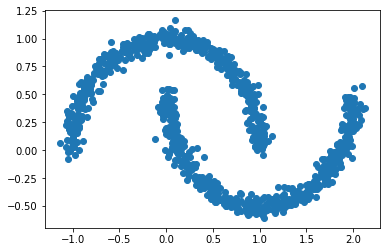

In [286]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, shuffle=True, noise=0.05, random_state=None)

plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

## Blob dataset

[[2.  0.5]
 [0.5 1. ]]


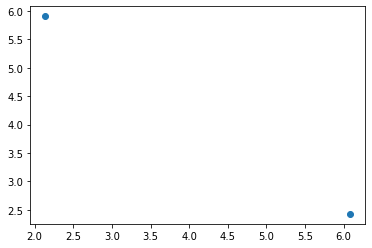


Covariance is positive definite.
(1000, 2)


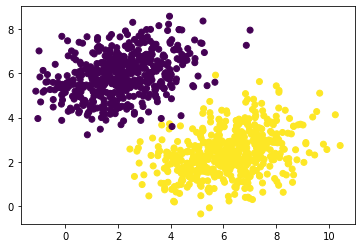

In [120]:
sample_blobs = sample_random_balls(2, var_x = 2, var_y = 1, var_xy = 0.5)
print(sample_blobs.covariance)
plt.figure()
plt.scatter(sample_blobs.mu[:, 0], sample_blobs.mu[:, 1])
plt.show()

X, l = sample_blobs.sample(1000)

print(X.shape)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = l)
plt.show()

## S dataset

There are an odd number of circles
(1000, 1) (1000, 1)


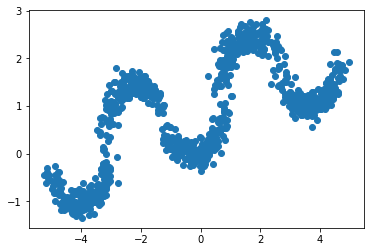

In [264]:
test = s_manifold_2d(5, radius = 1, noise_var = 0.14, rotation=15, y_offset = 1)
#print(test.circle_centers)
X = test.sample(1000)

plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

## Test SOM instance

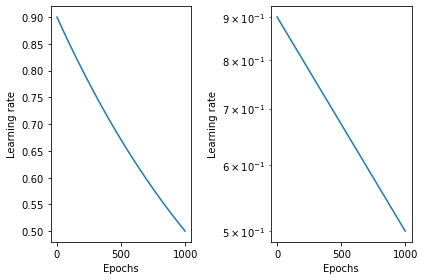

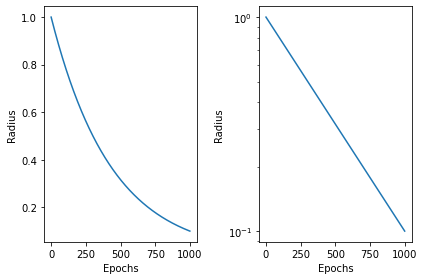

NameError: name 'X' is not defined

In [98]:
%matplotlib inline

SOM_instance = SOM(n_neurons = (20, 1), 
                   n_features = 2,
                   n_epochs = 1000,
                   n_init = 15,
                   lr = [0.9, 0.5], 
                   radius = [1, 0.1],
                   standardise_flag = True,
                   verbose = True)

#print(SOM_instance.lambda_lr, SOM_instance.lambda_radius, SOM_instance.lr_1)

epochs = np.arange(0, SOM_instance.n_epochs, 1)
    
fig, ax = plt.subplots(1, 2)
ax = ax.flatten()
ax[0].plot(epochs, SOM_instance.exponential_scheduler(epochs, lr_flag = True))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Learning rate")

ax[1].semilogy(epochs, SOM_instance.exponential_scheduler(epochs, lr_flag = True))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Learning rate")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2)
ax = ax.flatten()
ax[0].plot(epochs, SOM_instance.exponential_scheduler(epochs, lr_flag = False))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Radius")

ax[1].semilogy(epochs, SOM_instance.exponential_scheduler(epochs, lr_flag = False))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Radius")
plt.tight_layout()
plt.show()

#Fit model
SOM_instance.fit(X)


#Visualise
fig, ax = plt.subplots(1, 1)
ax.set_title("Training inertia")
ax.plot(SOM_instance.training_inertia_, label = "Inertia")
ax.set_xlabel("Epochs")
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1)
ax.set_title("Quantisation error")
ax.plot(SOM_instance.quantisation_error_, label = "Quantisation error")
ax.set_xlabel("Epochs")
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1)
ax.set_title("Training energy")
ax.plot(SOM_instance.training_energy_)
ax.set_xlabel("Epochs")
plt.show()

#Visualise
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], X[:, 1], c = l)
ax.scatter(SOM_instance.weights_[:, 0], SOM_instance.weights_[:, 1], color = "r", marker = "x")
ax = SOM_instance.plot_grid(ax)
plt.show()

fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], X[:, 1], c = l)
ax.scatter(SOM_instance.weights_[:, 0], SOM_instance.weights_[:, 1], c = np.arange(SOM_instance.weights_.shape[0]), cmap = plt.cm.cool)
ax = SOM_instance.plot_grid(ax)
plt.show()

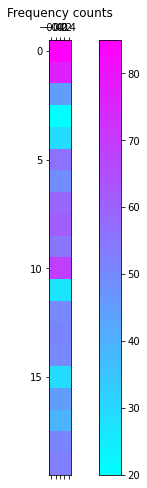

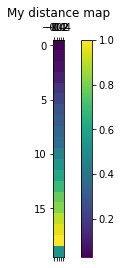

In [295]:
SOM_instance.frequency_map(X)

distance_map = SOM_instance.distance_map()

fig, ax = plt.subplots()
ax.set_title("My distance map")
m = ax.matshow(distance_map)
fig.colorbar(m, ax=ax)
plt.show()

(10000, 2)


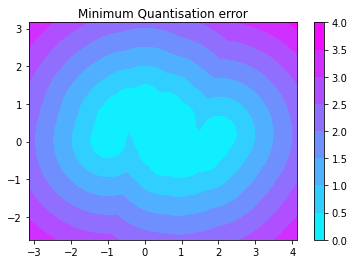

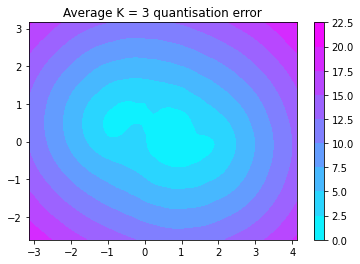

In [296]:
N = 100
K = 3
X1, Y1 = np.meshgrid(np.linspace(np.min(X[:, 0]) - 2, np.max(X[:, 0]) + 2, N), 
                   np.linspace(np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2, N))

XY1 = np.hstack((X1.reshape(-1, 1), Y1.reshape(-1, 1)))
print(XY1.shape)

Z1, Z2 = SOM_instance.compute_HIs(XY1, K = 5)

plt.figure()
plt.title("Minimum Quantisation error")
plt.contourf(X1, Y1, Z1.reshape(N, N), cmap = plt.cm.cool)
plt.colorbar()
plt.show()

plt.figure()
plt.title("Average K = {} quantisation error".format(K))
plt.contourf(X1, Y1, Z2.reshape(N, N), cmap = plt.cm.cool)
plt.colorbar()
plt.show()

## Compare to smith's implementation

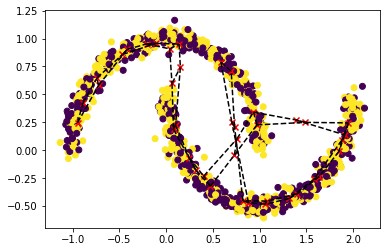

13.130742482428644 38.205176902681856


In [297]:
som_smith = SOM_smith(m=20, n=2, dim=2)
som_smith.fit(X)

fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], X[:, 1], c = l)


for i in range(som_smith.m * som_smith.n):
        
    P = som_smith.weights[i, :]
    ax.scatter(P[0], P[1], color = "r", marker = "x")
    

centers = som_smith.cluster_centers_

for i in range(centers.shape[0]):
    for j in range(centers.shape[1]):
        
        try:
            x1, y1 = centers[i, j, :]
            x2, y2 = centers[i, j + 1, :]

            ax.plot([x1, x2], [y1, y2], "k--")
        
        except:
            pass
        
        if i > 0:
            x1, y1 = centers[i - 1, j, :]
            x2, y2 = centers[i, j, :]

            ax.plot([x1, x2], [y1, y2], "k--")
            

#ax = SOM_instance.plot_grid(ax)
plt.show()

print(som_smith._inertia_, SOM_instance._inertia_)

## RBG Dataset
The goal here is for the model to group colours in a nice way, for a completely random RGB dataset

(10000, 3)


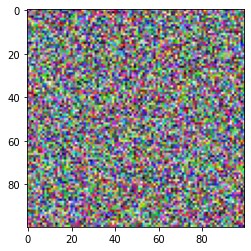

In [93]:
Nsamples = 10000
R = np.random.randint(low = 0, high = 255, size = (Nsamples, 1))
G = np.random.randint(low = 0, high = 255, size = (Nsamples, 1))
B = np.random.randint(low = 0, high = 255, size = (Nsamples, 1))

#Normalise so that the inputs are not integers but floats
X_colour = np.hstack((R, G, B)) / 255.0

print(X_colour.shape)

plt.figure()
plt.imshow(X_colour.reshape(np.sqrt(Nsamples).astype('int'), np.sqrt(Nsamples).astype('int'), 3))
plt.show()

### My implementation (with quantisation calculation)


Starting the SOM training!

Starting iteration 1...
Final inertia: 2807.3348
Final quantisation error: 0.4778

Finished SOM training!


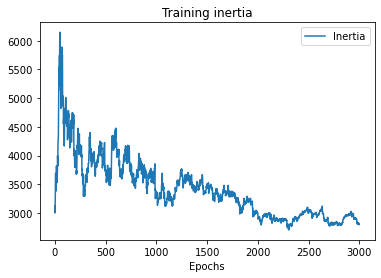

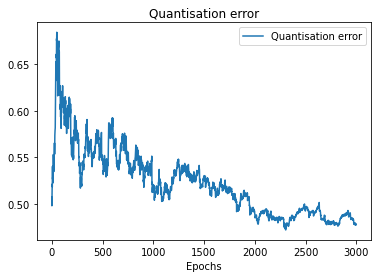

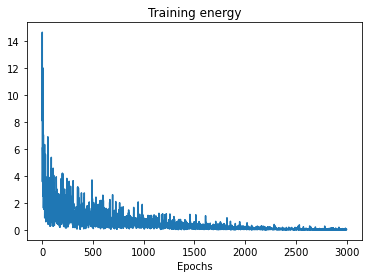

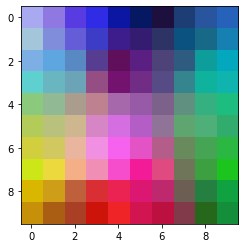

In [198]:
#Initialise model
SOM_instance = SOM(n_neurons = (10, 10), 
                   n_features = 3,
                   n_epochs = 3000,
                   n_init = 1, #Only 1 initialisation, as this is just a toy test
                   lr = [0.9, 0.5], 
                   radius = [1, 0.5],
                   standardise_flag = True,
                   verbose = True,
                   vectorise = True)

#Fit model
SOM_instance.fit(X_colour, True)

#Visualise
fig, ax = plt.subplots(1, 1)
ax.set_title("Training inertia")
ax.plot(SOM_instance.training_inertia_, label = "Inertia")
ax.set_xlabel("Epochs")
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1)
ax.set_title("Quantisation error")
ax.plot(SOM_instance.quantisation_error_, label = "Quantisation error")
ax.set_xlabel("Epochs")
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1)
ax.set_title("Training energy")
ax.plot(SOM_instance.training_energy_)
ax.set_xlabel("Epochs")
plt.show()

Weights = SOM_instance.weights_.reshape(SOM_instance.n_rows, SOM_instance.n_cols, -1)

plt.figure()
plt.imshow(Weights.clip(0, 1))
plt.show()

### My implementation (without quantisation calculation)


Starting the SOM training!

Starting iteration 1...
Final inertia: 0.0000
Final quantisation error: 0.0000

Finished SOM training!


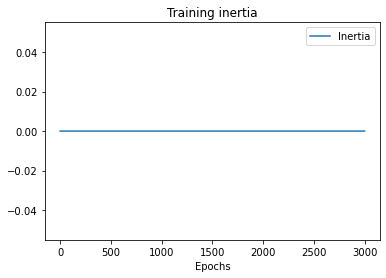

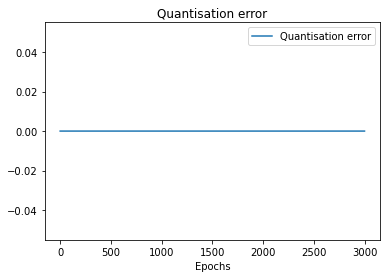

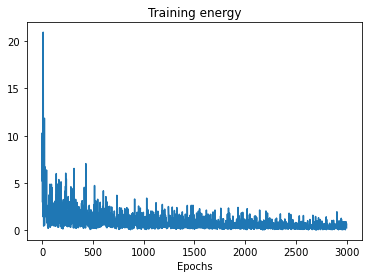

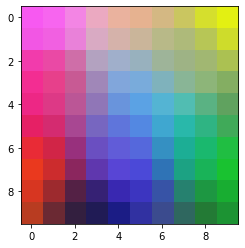

In [195]:
#Initialise model
SOM_instance = SOM(n_neurons = (10, 10), 
                   n_features = 3,
                   n_epochs = 3000,
                   n_init = 1, #Only 1 initialisation, as this is just a toy test
                   lr = [0.9, 0.5], 
                   radius = [1, 0.99],
                   standardise_flag = True,
                   verbose = True,
                   vectorise = True)

#Fit model
SOM_instance.fit(X_colour, False)

#Visualise
fig, ax = plt.subplots(1, 1)
ax.set_title("Training inertia")
ax.plot(SOM_instance.training_inertia_, label = "Inertia")
ax.set_xlabel("Epochs")
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1)
ax.set_title("Quantisation error")
ax.plot(SOM_instance.quantisation_error_, label = "Quantisation error")
ax.set_xlabel("Epochs")
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1)
ax.set_title("Training energy")
ax.plot(SOM_instance.training_energy_)
ax.set_xlabel("Epochs")
plt.show()

Weights = SOM_instance.weights_.reshape(SOM_instance.n_rows, SOM_instance.n_cols, -1)

plt.figure()
plt.imshow(Weights.clip(0, 1))
plt.show()

### Compare to Smith's implementation

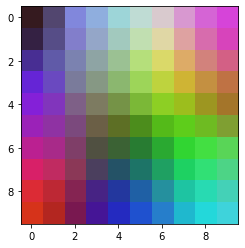

In [196]:
som_smith = SOM_smith(m=10, n=10, dim=3)
som_smith.fit(X_colour)

plt.figure()
plt.imshow(som_smith.cluster_centers_.clip(0, 1))
plt.show()